# Прогнозирование заказов такси

## Контекст

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

---
---

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

---
---

## Необходимо:

- Загрузить данные и выполнить их ресемплирование по одному часу.
- Проанализировать данные.
- Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
- Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле taxi.csv. Количество заказов находится в столбце num_orders


## Навигация (структура VS Code)






In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functions import time_rolling_ryad_plot, plot_mean_value_to_period
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
import joblib
from xgboost import XGBRegressor
from xgboost import plot_importance

RANDOM_STATE = 42

# Просмотр данных

In [3]:
data_base = pd.read_csv('taxi.csv')
data = data_base.copy()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
min_time = data['datetime'].min()
max_time = data['datetime'].max()

print(f'минимальное время представленное в датасете: {min_time}')
print(f'максимальное время представленное в датасете: {max_time}')

минимальное время представленное в датасете: 2018-03-01 00:00:00
максимальное время представленное в датасете: 2018-08-31 23:50:00


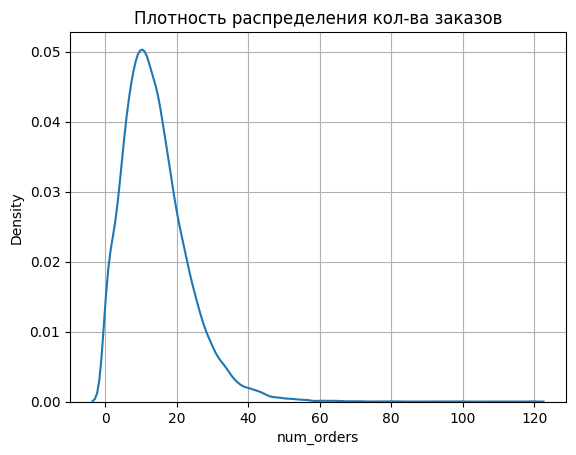

In [5]:
sns.kdeplot(data = data,
            x = 'num_orders')
plt.title('Плотность распределения кол-ва заказов')
plt.grid()

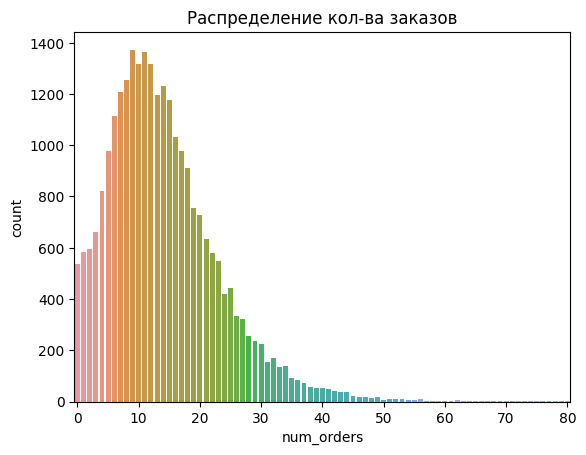

In [6]:
sns.countplot(data = data,
              x = 'num_orders')
plt.title('Распределение кол-ва заказов')
plt.xscale('linear')

##### вывод по данным

- минимальное время:  2018-03-01 00:00:00
- максимальное время: 2018-08-31 23:50:00
- количество заказов распределено ассиметрично

# Ресемплирование по одному часу

In [7]:
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.set_index('datetime').resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


# Анализ данных

In [8]:
data = data['num_orders']

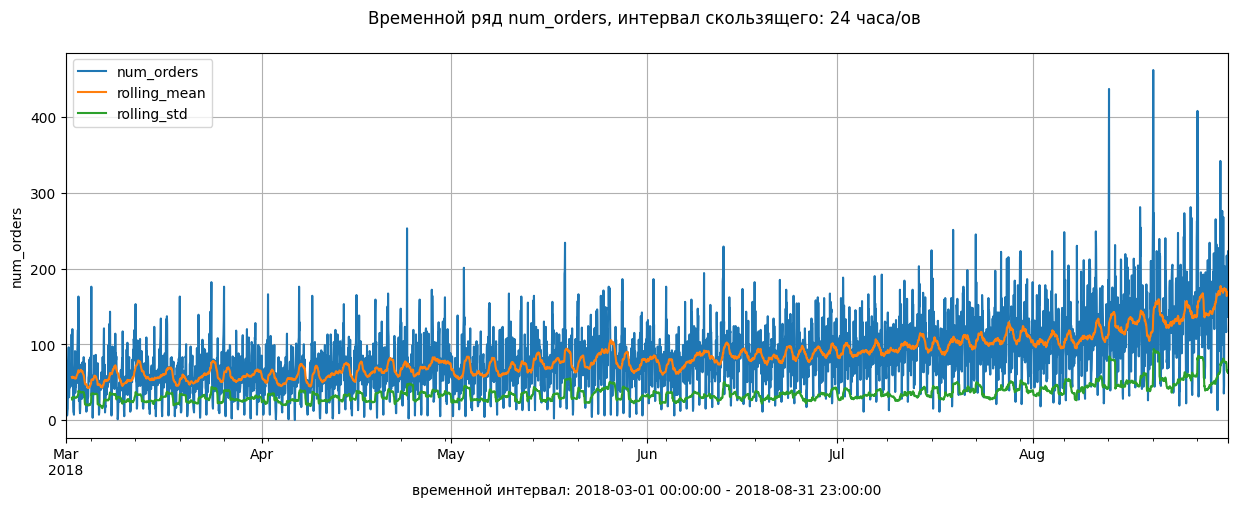

In [9]:
time_rolling_ryad_plot(data)

- тенденция к росту
- также рост дисперсии под конец периода

Посмотрим подробнее на период роста (это июль - август)

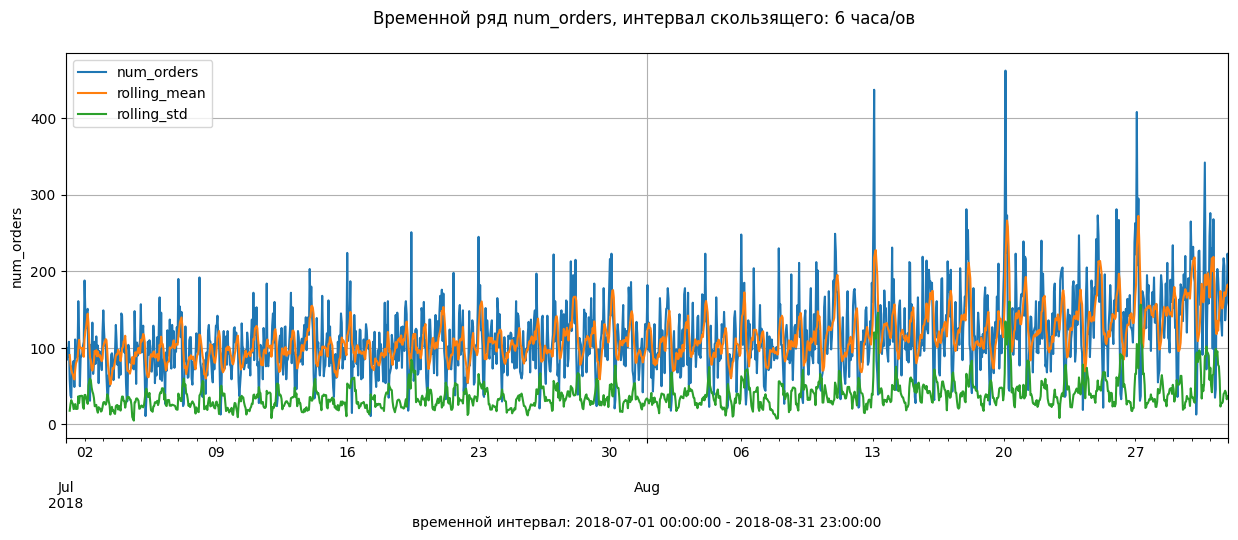

In [10]:
time_rolling_ryad_plot(data = data['2018-07-01':'2018-08-31'],
                       rolling_size = 6)

Очевидно - с ростом показателей num_orders --> растет и скользящее среднее, и дисперсия

Посмотрим ближе на период с самыми большими скачками 13-31 августа

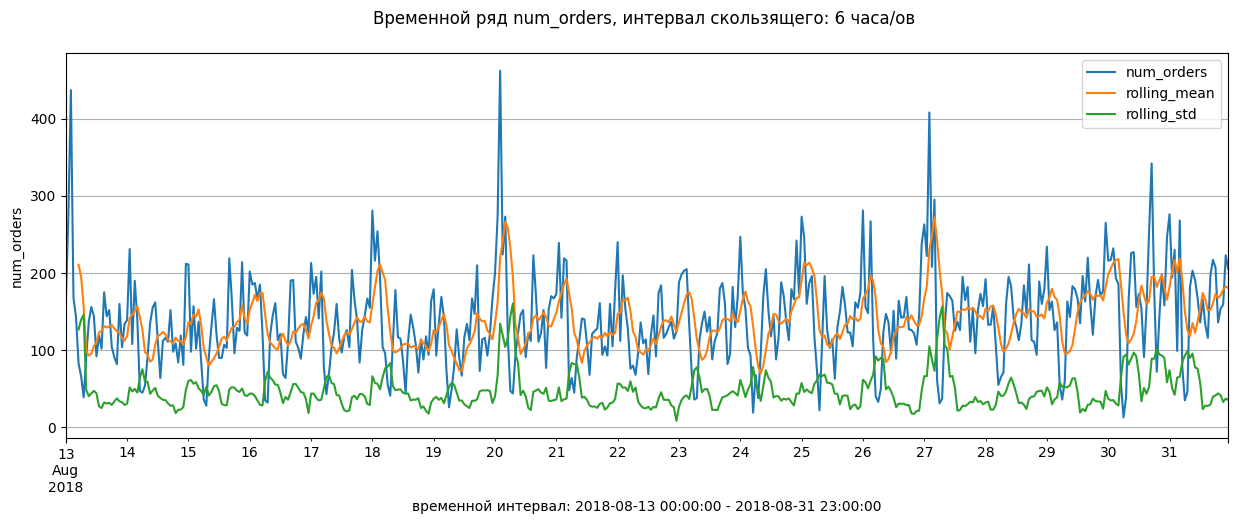

In [11]:
time_rolling_ryad_plot(data = data['2018-08-13':'2018-08-31'],
                       rolling_size = 6)

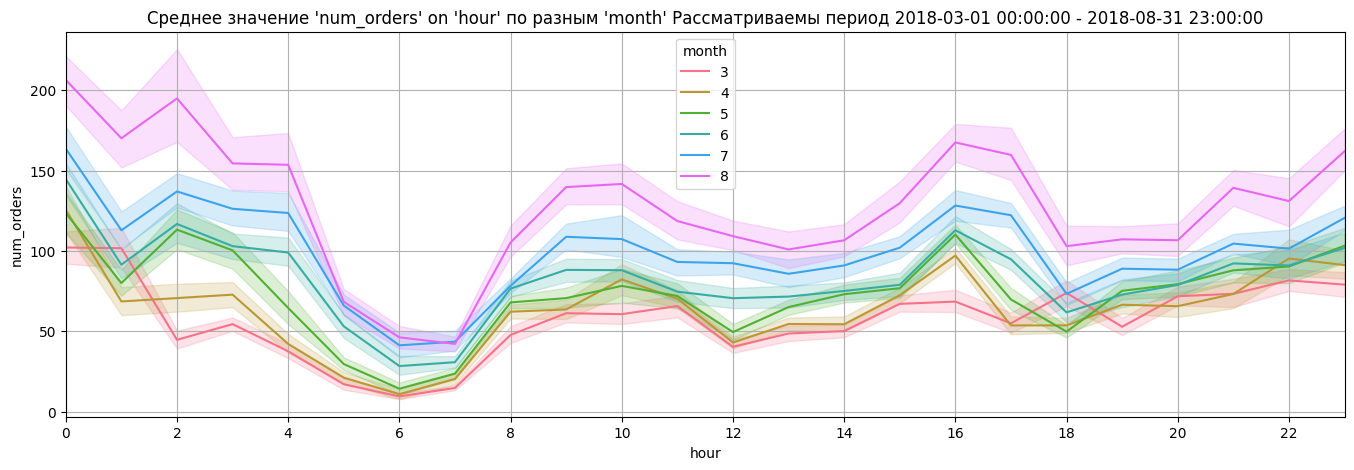

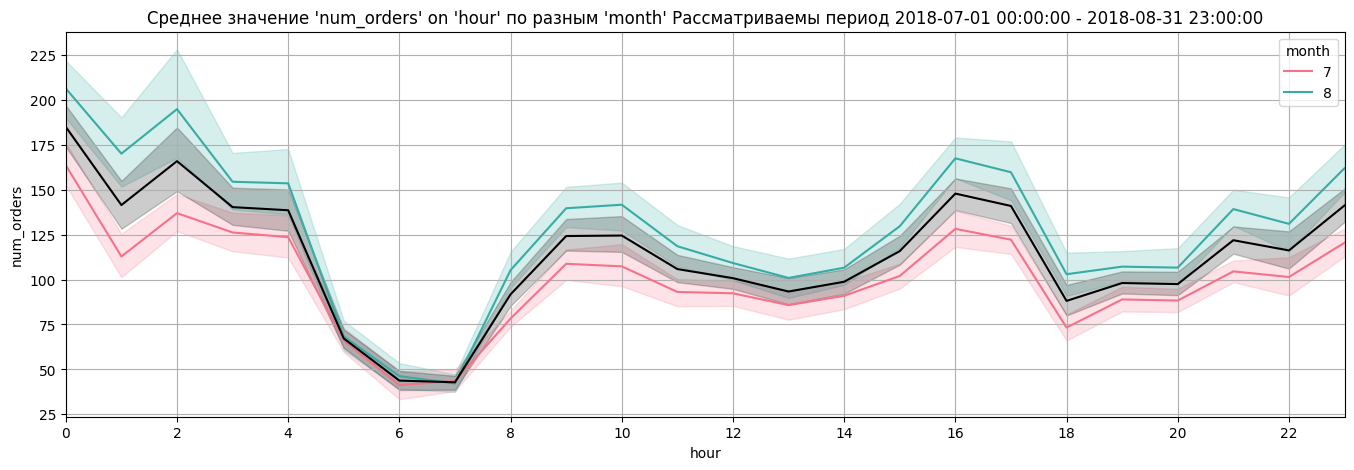

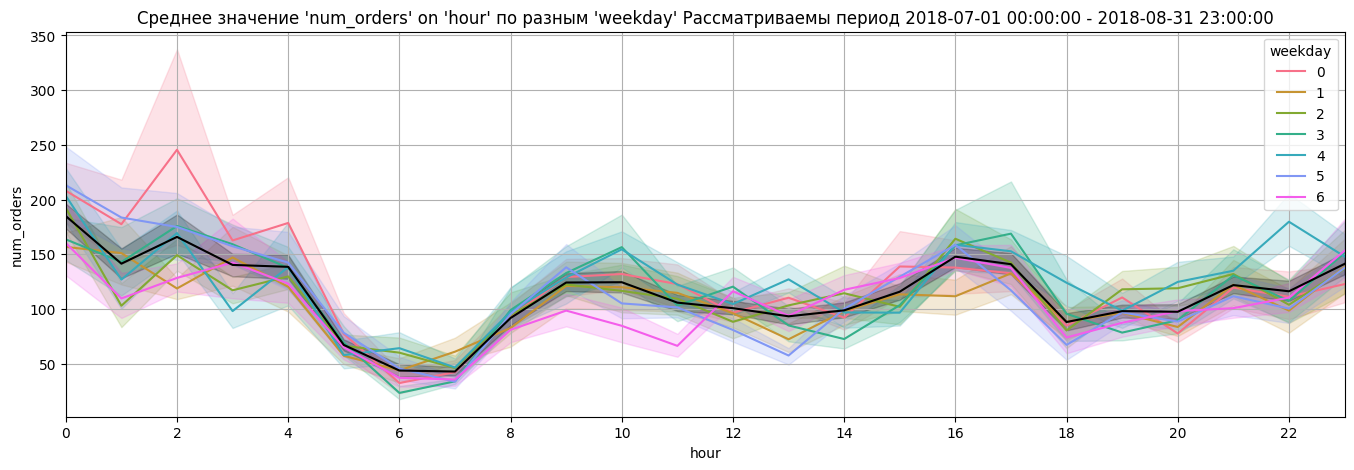

In [12]:
plot_mean_value_to_period(data, x='hour', hue='month')
plot_mean_value_to_period(data['2018-07-01':'2018-08-31'], x = 'hour', hue = 'month', tot = True)
plot_mean_value_to_period(data['2018-07-01':'2018-08-31'], x = 'hour', hue = 'weekday', tot = True)

- спад кол-ва заказов:  0-6, 10-12, 16-18 часов
- рост кол-ва заказов: 7-9, 14-16, 18-23 часов

Text(0, 0.5, 'частота')

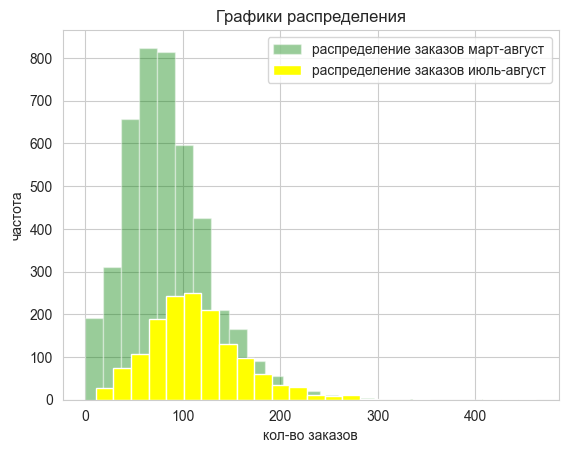

In [13]:
df_distr = data.reset_index()
df_distr = df_distr[(df_distr['datetime'] >= '2018-07-01') & (df_distr['datetime'] <= '2018-08-31 23:00:00')]

sns.set_style('whitegrid')

data.reset_index()['num_orders'].plot(kind = 'hist',
                                      color = 'green',
                                      bins = 25,
                                      alpha = 0.4,
                                      label = 'распределение заказов март-август')

df_distr['num_orders'].plot(kind = 'hist',
                            color = 'yellow',
                            bins = 25,
                            label = 'распределение заказов июль-август')
plt.legend()
plt.title('Графики распределения')
plt.xlabel('кол-во заказов')
plt.ylabel('частота')

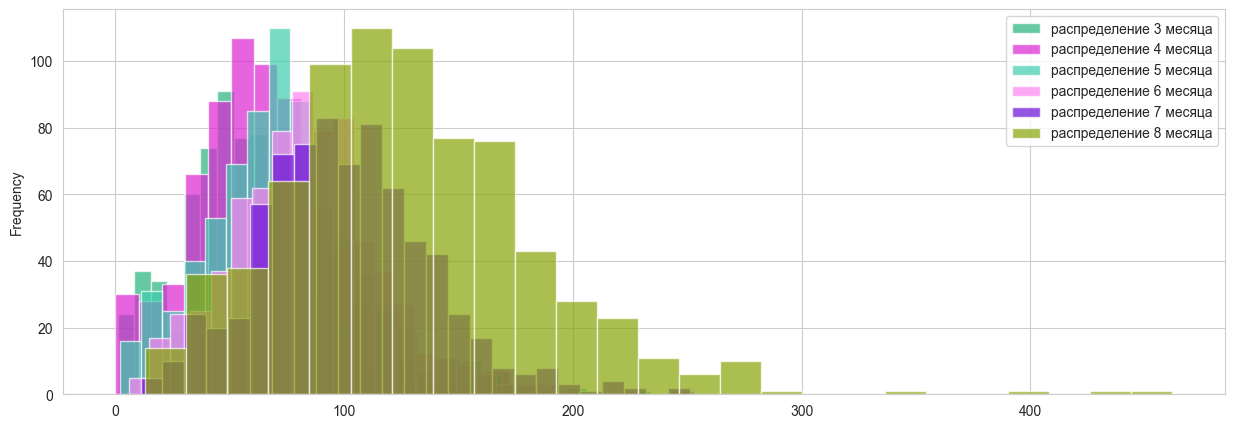

In [14]:
# посмотрим на распределения всех месяцев
sns.set_style('whitegrid')

months = [3,4,5,6,7,8]
plt.figure(figsize = (15,5))
for i in months:
    min_day_of_month = data[f'2018-0{i}'].index.min()
    max_day_of_month = data[f'2018-0{i}'].index.max()
    dataset_to_plot = data[f'{min_day_of_month}': f'{max_day_of_month}']
    dataset_to_plot.plot(kind = 'hist',
                         bins = 25,
                         alpha = 0.7,
                         color = np.random.rand(len(months), 3),
                         label = f'распределение {i} месяца')
    plt.legend()
plt.show()

# Статистическая проверка Дики-Фуллера

- H0 - ряд не стационарный
- H1 - ряд стационарный

In [15]:
alpha = 0.05

def fuller_test(data, alpha):
    '''
    H0 - ряд не стационарный
    H1 - ряд стационарный
    '''

    itog = adfuller(data)
    statistic = itog[0]
    p_value = itog[1]
    print('Статистика Дики-Фуллера: {0:.3f}'.format(statistic))
    print('p-value: {0:.3f}'.format(p_value))
    if p_value < alpha:
        print(f'ОТТВЕРГАЕМ нулевую гипотезу на уровне значимости: {alpha}')
        print('Временной ряд --> СТАЦИОНАРНЫЙ')
    else:
        print(f'ПРИНИМАЕМ нулевую гипотезу на уровне значимости {alpha}')
        print('Временной ряд --> НЕ СТАЦИОНАРНЫЙ')
    print('\n')
    print('Статистика критических значений:')
    for key, value in itog[4].items():
        print('\t%s: %.3f' % (key, value))




fuller_test(data, 0.05)

Статистика Дики-Фуллера: -3.069
p-value: 0.029
ОТТВЕРГАЕМ нулевую гипотезу на уровне значимости: 0.05
Временной ряд --> СТАЦИОНАРНЫЙ


Статистика критических значений:
	1%: -3.432
	5%: -2.862
	10%: -2.567


# Проверка сезонности / тренда

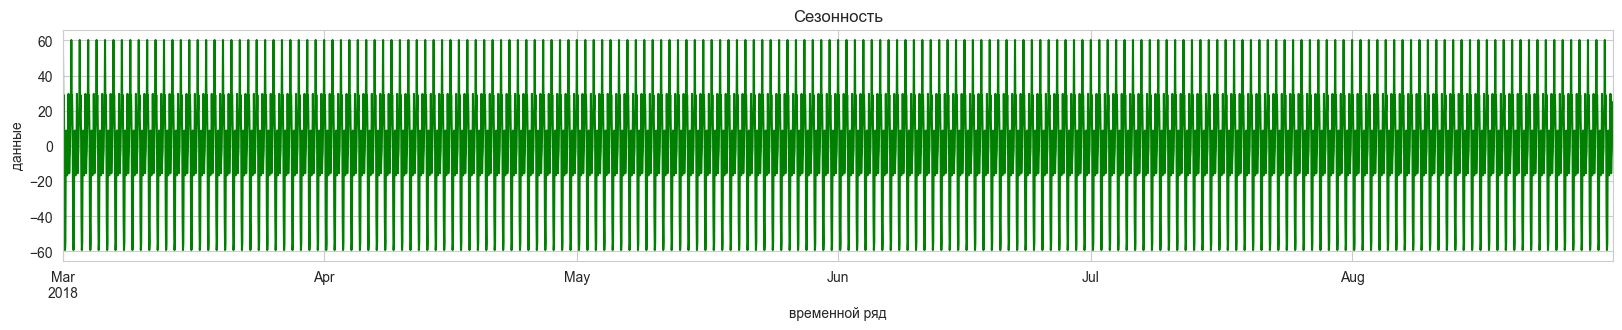

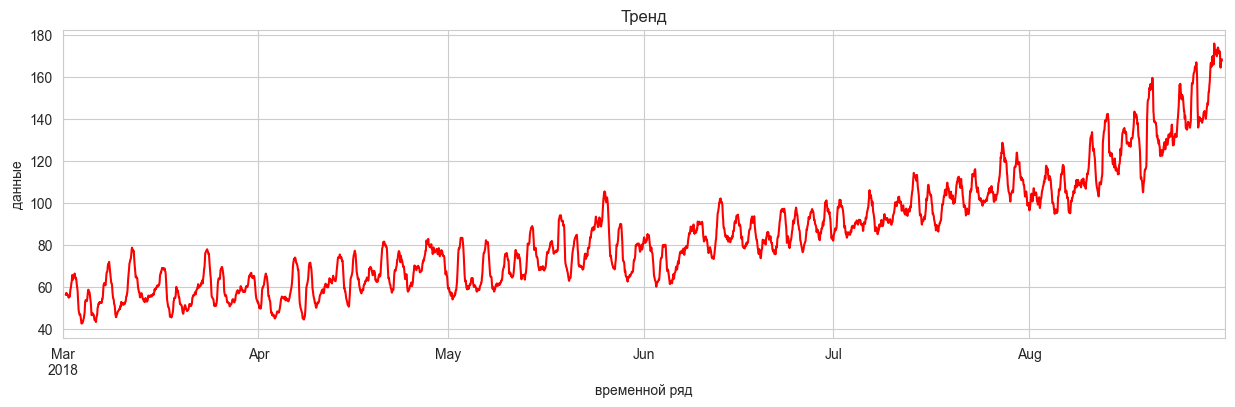

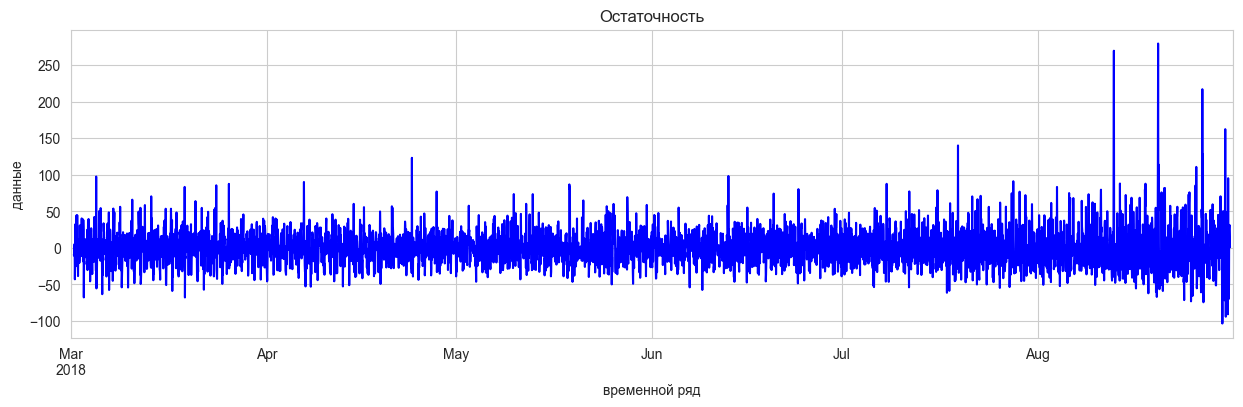

In [16]:
def decomposition_plot(data):

    import statsmodels.api as sm

    # график сезонности
    plt.figure(figsize = (20,3))
    decopmosition = sm.tsa.seasonal_decompose(data)
    decopmosition.seasonal.plot(color = 'green')
    plt.title('Сезонность')
    plt.xlabel('временной ряд')
    plt.ylabel('данные')
    plt.show()

    # график тренда
    plt.figure(figsize = (15,4))
    decopmosition.trend.plot(color = 'red')
    plt.title('Тренд')
    plt.xlabel('временной ряд')
    plt.ylabel('данные')
    plt.show()

    # Остаточный график    
    plt.figure(figsize = (15,4))
    decopmosition.resid.plot(color = 'blue')
    plt.title('Остаточность')
    plt.xlabel('временной ряд')
    plt.ylabel('данные')
    plt.show()


decomposition_plot(data)


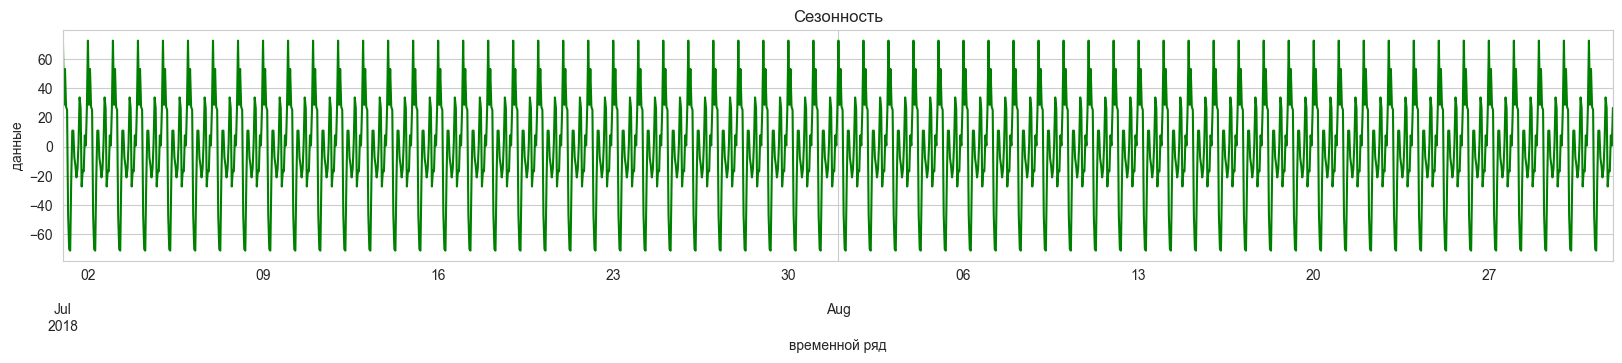

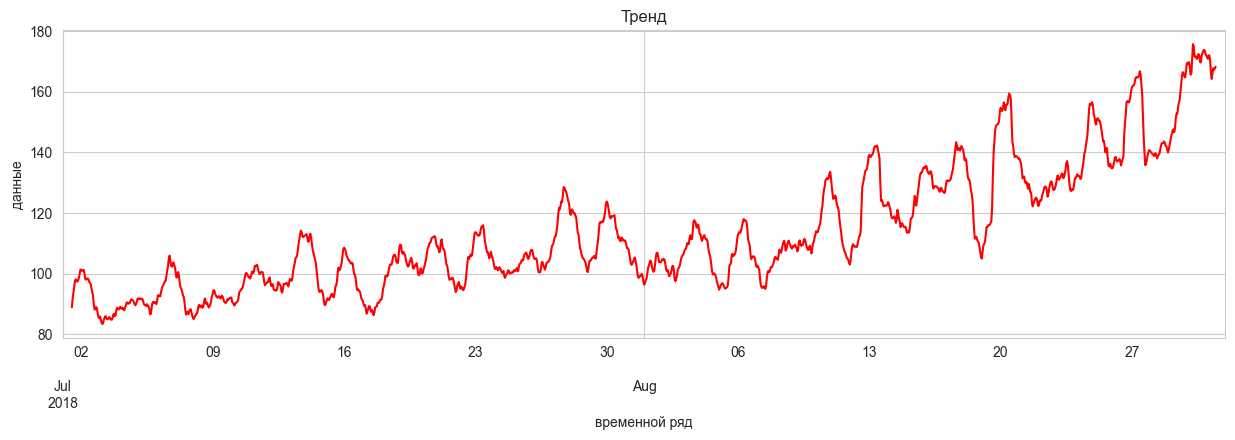

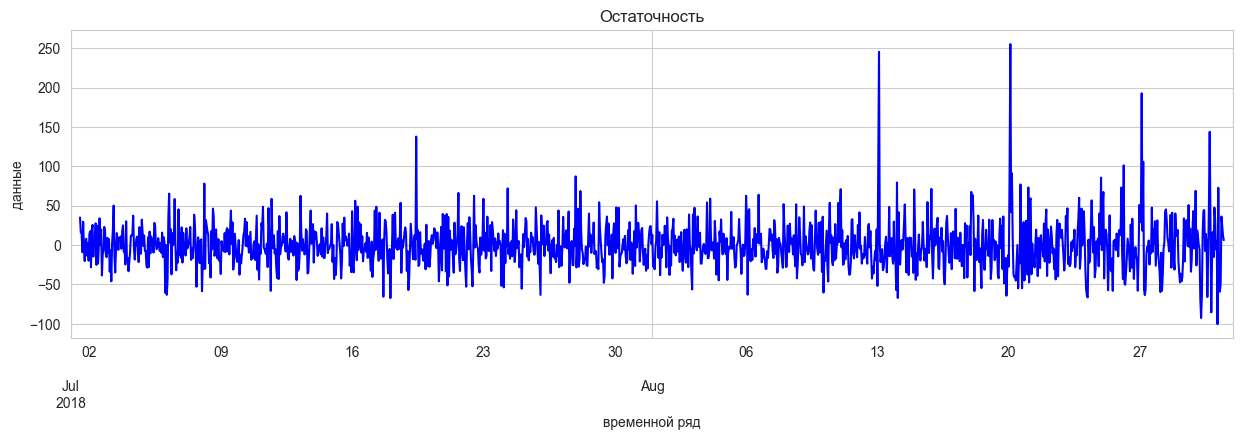

In [17]:
# Построим те же графики для последних двух месяцев

decomposition_plot(data['2018-07-01': '2018-08-31'])

заметные всплески значений, рассморим их поближе, рассмотрев последние недели июля и августа

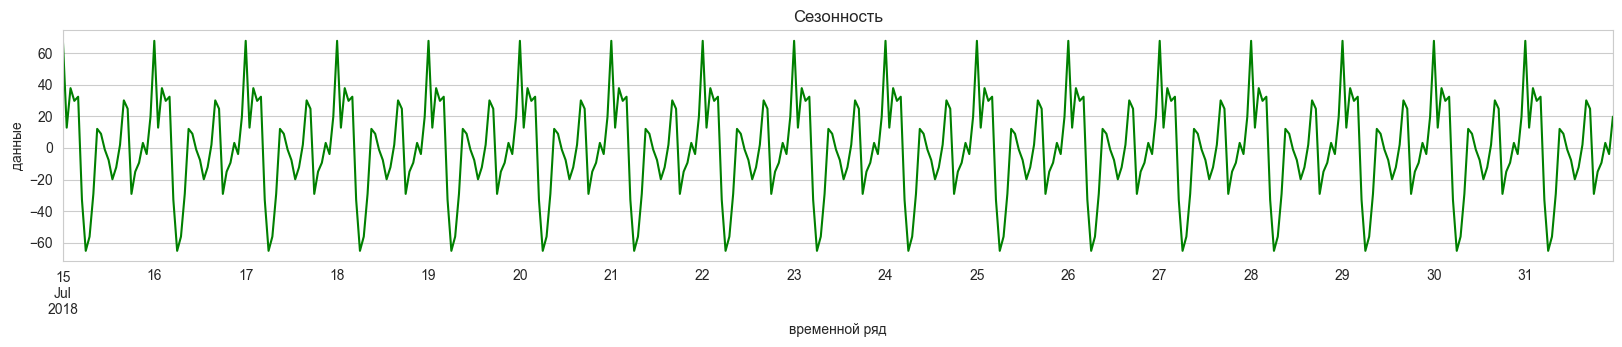

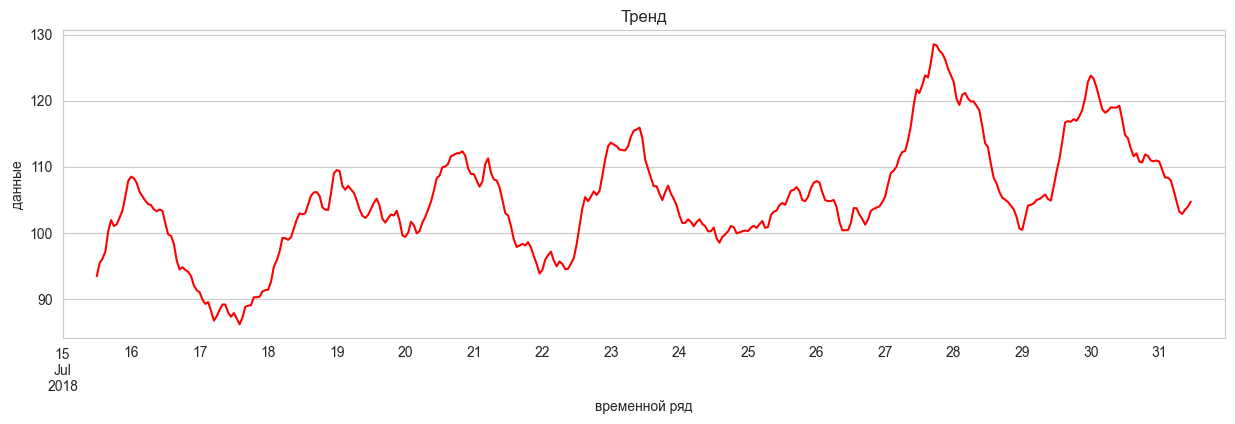

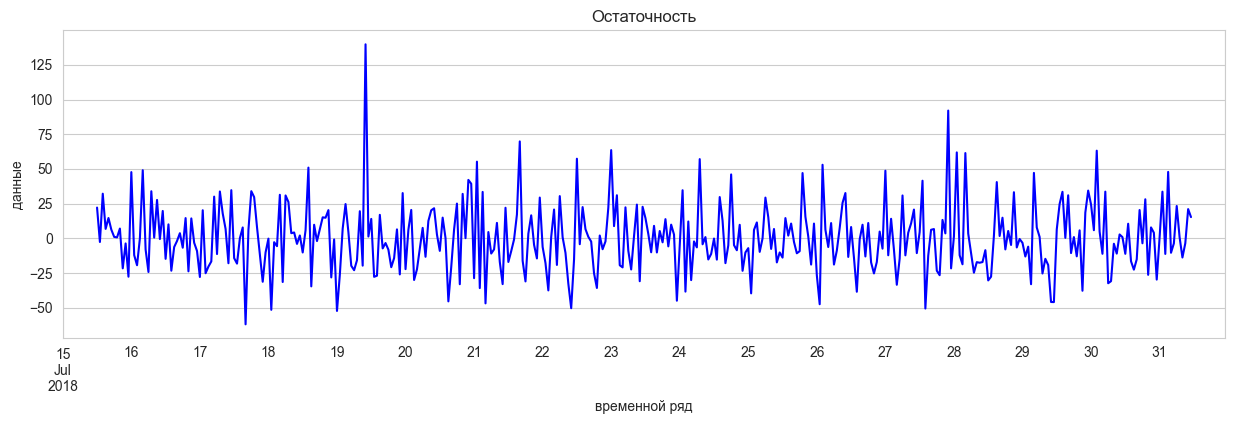

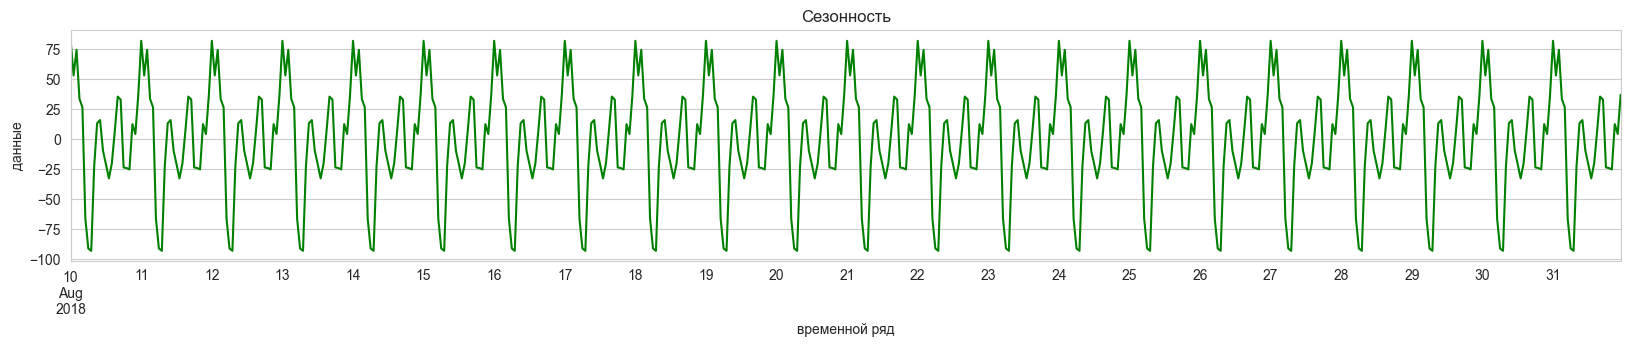

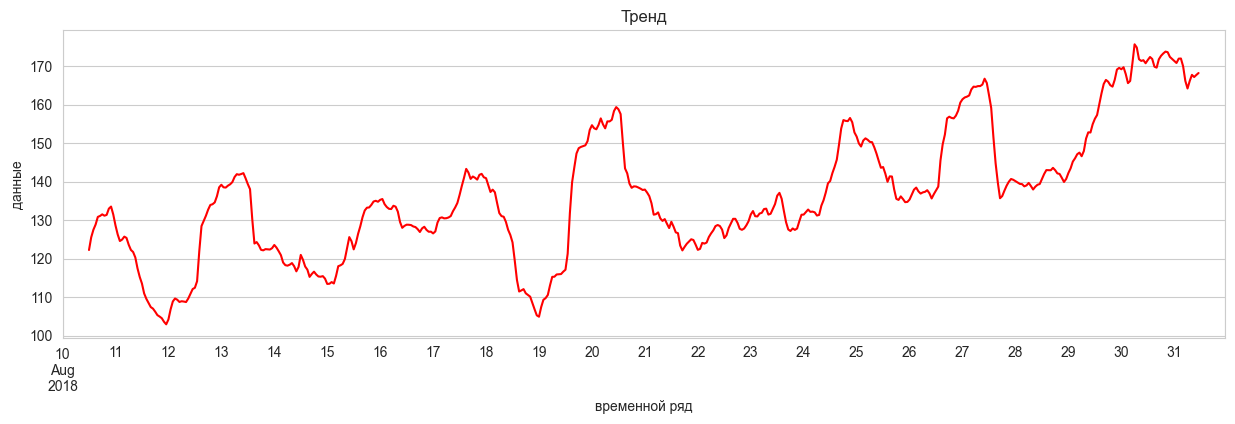

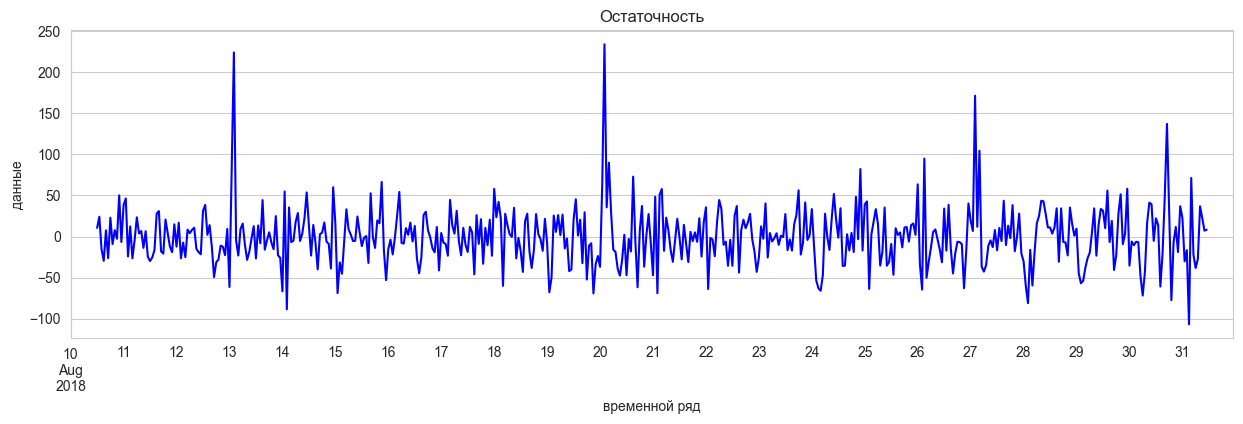

In [18]:
decomposition_plot(data['2018-07-15': '2018-07-31'])
decomposition_plot(data['2018-08-10': '2018-08-31'])

сезонность схожа


# Коэффициенты автокорреляции

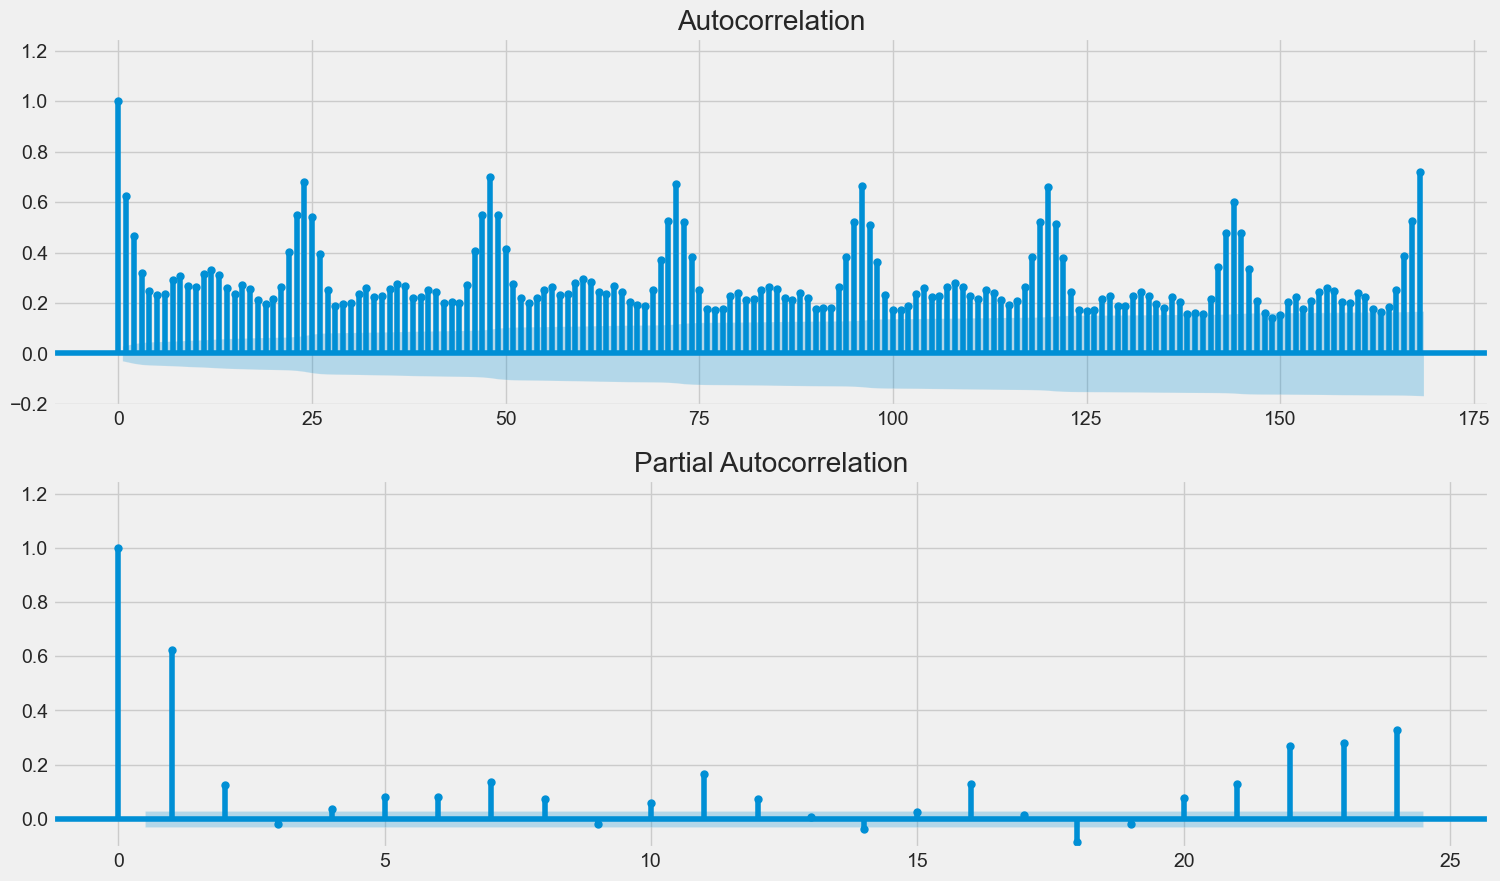

In [83]:
fig, ax = plt.subplots(nrows = 2,
                       ncols = 1,
                       figsize = (16.5,10))
plot_acf(data,
         ax = ax[0],
         lags = 24*7,
         auto_ylims = True);

plot_pacf(data,
          ax = ax[1],
          lags = 24,
          auto_ylims = True);

Вывод по автокорреляции:

- все коэффициенты автокорреляции выше 0 не только для дневной сезонности, но и для недельной
- при скипе малых задержек, наблюдается незначительная отрицательная автокорелляция 

# Создание признаков и обучение моделей

#### Создание признаков

In [19]:
# Напишем функцию создания признаков временного ряда

def datetime_features(data,
                      calendar_features,
                      shift_feature,
                      diff_feature,
                      rolling_mean_interval):
    '''   
    data - это формат сериес или датафрейм (где индекс - время)
    calendar_features - список признаков (Например: ['weekday', 'day', 'month'])
    shift_features - число сдвига вниз по таблице на определенное значение (отстающее значение). Например, если временной индекс почасовой, то можно сдвиг на 24
    diff_feature - число сдвига вниз, для последующей разницы сдвига и не сдвига
    rolling_mean_interval - число, которое характеризует сдвиг для скользящего (интервал скользящего)
    '''
    # Создаем датафрем с индеском времени
    df = pd.DataFrame(index = data.index)

    # Пытаемся создать календарные признаки
    if calendar_features:
        for feature in calendar_features:
            try:
                df[feature] = getattr(data.index, feature)
            except:
                print(f'Календартного признака {feature} нет в списке или не возможно взять атрибут {feature} из времени')
    
    # Пытаемся создать отстающие признаки
    if shift_feature:
        for number_of_shift in range(1, shift_feature+1):
                df[f'shift_to_{number_of_shift}'] = data.shift(number_of_shift)
    '''else:
         print('Не указан параметр shift_feature')'''
               
    # Пытаемся создать диффренциированные признаки
    if diff_feature:
            if diff_feature > 0:
                df['diff_1'] = data.shift(1) - data.shift(2)
            if diff_feature > 1:
                 for sdvig in range(2, diff_feature + 1):
                    df[f'diff_{sdvig}'] = df[f'diff_{sdvig - 1}'] - df[f'diff_{sdvig - 1}'].shift(1)
    '''else:
         print('Не указан параметр diff_feature')'''


    # Пытаемся создать признак скользящего среднего
    if rolling_mean_interval:
        df[f'rolling_mean_{rolling_mean_interval}'] = data.shift(1).rolling(rolling_mean_interval).mean()
    '''else:
        print('Не указан параметр rolling_mean_interval')'''

    return df

In [20]:
# Создадим тренировочные, валидационные, тестовые метки. Позже увидим датасет, на котором ошибка будет наименьшая 
# и подготовим матрицу признаков для X_test

y_train, y_test = train_test_split(data,
                                   test_size = 0.1,
                                   shuffle = False)

y_train, y_val = train_test_split(y_train,
                                  test_size = 0.2,
                                  shuffle = False)

In [21]:
def model_learning(model,
                   y_train,
                   y_val):
    
    shift_features = []
    diff_features = []
    rolling_mean_features = []
    RMSE_all = []

    # Подготовка датасетов
    for sf in range(1, 31, 1):
        for df in range(0, 4 ,1):
            for rmi in [6,12,24,48,72,96,7*24]:
                
                # матрица признаков
                X = datetime_features(data,
                                      calendar_features = ['day', 'weekday'],
                                      shift_feature = sf,
                                      diff_feature = df,
                                      rolling_mean_interval = rmi)
                

                X_train = X.loc[y_train.index].dropna()
                X_val = X.loc[y_val.index].dropna()
                
                y_train = y_train.loc[X_train.index]
                y_val = y_val.loc[X_val.index]
                # Обучение модели
                model.fit(X_train, y_train)
                y_pred = model.predict(X_val)
                # Расчет RMSE
                RMSE = mean_squared_error(y_true = y_val,
                                          y_pred = y_pred,
                                          squared = False)
                
                # Подготовка итоговой таблицы гиперпараметров и RMSE
                # Гиперпараметры
                shift_features.append(sf)
                diff_features.append(df)
                rolling_mean_features.append(rmi)
                # RMSE
                RMSE_all.append(RMSE)

    df = pd.DataFrame({'shift_features': shift_features,
                       'diff_features': diff_features,
                       'rolling_mean_features': rolling_mean_features,
                       'RMSE': RMSE_all})

    return df

#### Обучение моделей

##### BASE LinearRegression

In [22]:
model = LinearRegression()

linear_base_model_report =\
model_learning(model,
               y_train,
               y_val)

linear_base_model_report

,shift_features,diff_features,rolling_mean_features,RMSE
0,1,0,6,42.010912
1,1,0,12,40.971448
2,1,0,24,39.062596
3,1,0,48,38.814818
4,1,0,72,38.643269
...,...,...,...,...
835,30,3,24,33.397734
836,30,3,48,33.275145
837,30,3,72,32.650194
838,30,3,96,32.822627


In [23]:
df_itog = linear_base_model_report.sort_values(by = 'RMSE')
df_itog

,shift_features,diff_features,rolling_mean_features,RMSE
818,30,0,168,32.597177
825,30,1,168,32.597177
830,30,2,72,32.602661
832,30,2,168,32.604505
837,30,3,72,32.650194
...,...,...,...,...
112,5,0,6,41.876980
147,6,1,6,41.882724
28,2,0,6,41.919172
7,1,1,6,41.919172


In [24]:
df_itog[(df_itog['rolling_mean_features'] == 24) & (df_itog['shift_features'] == 24)]

,shift_features,diff_features,rolling_mean_features,RMSE
660,24,2,24,33.136505
646,24,0,24,33.136845
667,24,3,24,33.137676
653,24,1,24,33.150959


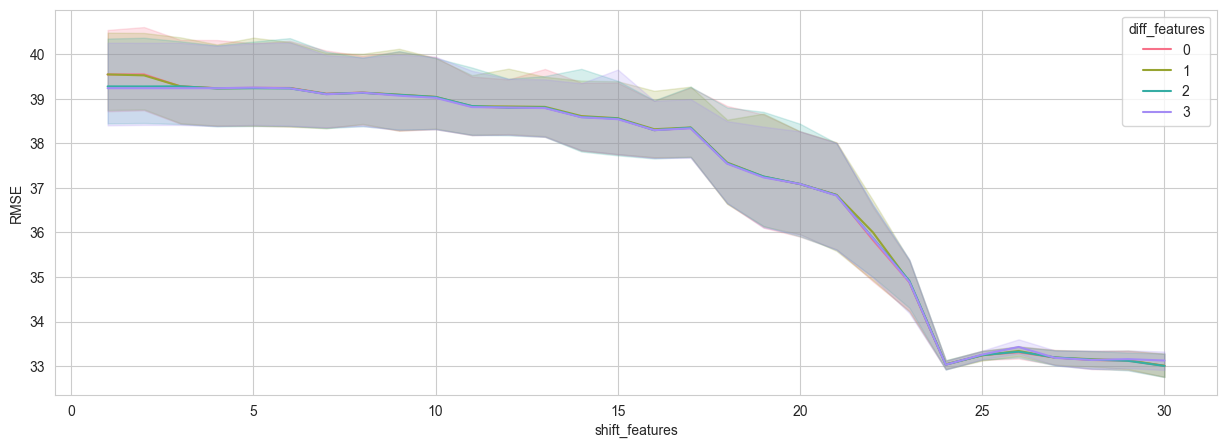

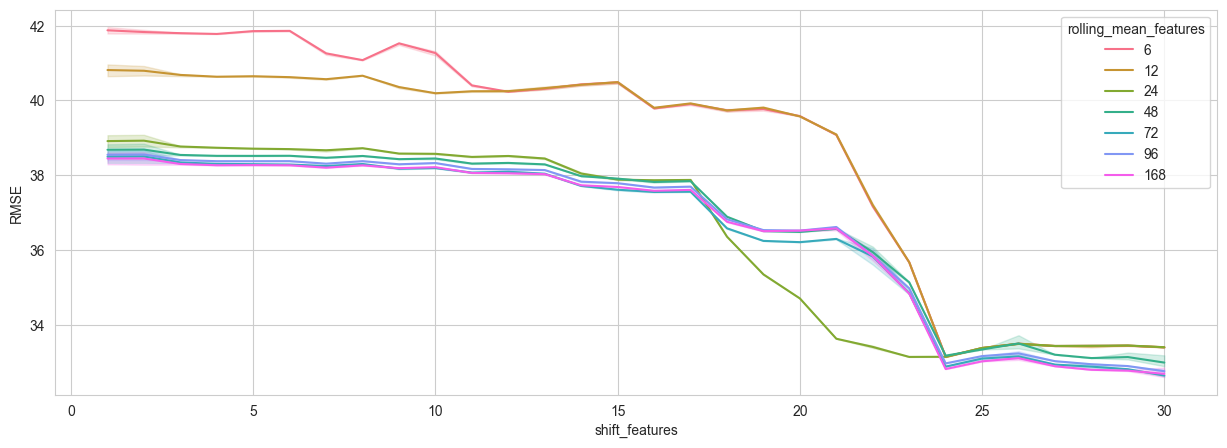

In [25]:
plt.figure(figsize = (15,5))
sns.lineplot(data = linear_base_model_report,
             x = 'shift_features',
             y = 'RMSE',
             hue = 'diff_features',
             palette = sns.color_palette('husl', 4))

plt.grid(visible = True)
plt.show()
    

    
plt.figure(figsize = (15,5))
sns.lineplot(data = linear_base_model_report,
             x = 'shift_features',
             y = 'RMSE',
             hue = 'rolling_mean_features',
             palette = sns.color_palette('husl', 7))
plt.grid(visible = True)
plt.show()

выберем:

- shift_features = 24
- diff_features = 1
- rolling_mean_features = 24

In [26]:
# Итоговые наши выборки

X = datetime_features(data,
                      calendar_features = ['day', 'weekday'],
                      shift_feature = 24,
                      diff_feature = 1,
                      rolling_mean_interval = 24)
                

X_train = X.loc[y_train.index].dropna()
X_val = X.loc[y_val.index].dropna()
X_test = X.loc[y_test.index].dropna()
                
y_train = y_train.loc[X_train.index]
y_val = y_val.loc[X_val.index]
y_test = y_test.loc[X_test.index]

In [27]:
# Параметры кросс валидации

time_cross = TimeSeriesSplit(n_splits = 3,
                             test_size = 24*7*3)

cv_params = {'scoring': 'neg_mean_squared_error',
             'return_train_score': True,
             'cv': time_cross}

#### Функция обучения

In [28]:
# Функция вывода кросс валидации grid модели

def print_result(grid_model,
                 name):

    # Тренировка
    grid_model.fit(X_train, y_train)

    RMSE_train = np.sqrt((-1)*grid_model.cv_results_['mean_train_score'])
    RMSE_test = np.sqrt((-1)*grid_model.cv_results_['mean_test_score'])
    RMSE_best_score = np.sqrt((-1)*grid_model.best_score_).round(2) # На тесте
    time_fit = grid_model.cv_results_['mean_fit_time']
    time_score = grid_model.cv_results_['mean_score_time']
    try:
        n_estimators = [grid_model.cv_results_['params'][i]['n_estimators'] for i in range(0, len(grid_model.cv_results_['params']))]
    except:
        iterations = [grid_model.cv_results_['params'][i]['iterations'] for i in range(0, len(grid_model.cv_results_['params']))]
        learning_rate = [grid_model.cv_results_['params'][i]['learning_rate'] for i in range(0, len(grid_model.cv_results_['params']))]



    # Вывод результатов
    print(grid_model.estimator)
    print('Лучшие параметры {}'.format(grid_model.best_params_))
    print('Количество оценщиков: {}'.format(len(grid_model.cv_results_['params'])))
    print('Лучшая оцека RMSE: {}'.format(RMSE_best_score))

    try:
        df = pd.DataFrame({'RMSE_test': RMSE_test,
                        'RMSE_train': RMSE_train,
                        'fit_time': time_fit,
                        'score_time': time_score,
                        'n_estimators': n_estimators})
    except:
        df = pd.DataFrame({'RMSE_test': RMSE_test,
                           'RMSE_train': RMSE_train,
                           'fit_time': time_fit,
                           'score_time': time_score,
                           'iterations': iterations,
                           'learning_rate': learning_rate})
    
    
    best_model = grid_model.best_estimator_
    name = name+f'__{RMSE_best_score}__.pkl'
    joblib.dump(best_model, name)
    
    return df

##### RandomForest

In [29]:
grid_model_rf = GridSearchCV(estimator = RandomForestRegressor(random_state = RANDOM_STATE),
                             param_grid = {'n_estimators': np.arange(10, 101, 10)},
                             **cv_params,
                             n_jobs = 10)

data_results =\
print_result(grid_model_rf,
             name = 'rf1')

data_results.sort_values(by = 'RMSE_test')

RandomForestRegressor(random_state=42)
Лучшие параметры {'n_estimators': 100}
Количество оценщиков: 10
Лучшая оцека RMSE: 24.45


,RMSE_test,RMSE_train,fit_time,score_time,n_estimators
9,24.452887,7.423261,3.543423,0.010352,100
8,24.506072,7.430435,3.410995,0.009642,90
7,24.548807,7.450521,3.141574,0.009678,80
6,24.566330,7.470654,2.909910,0.010306,70
4,24.601994,7.528786,2.074550,0.007644,50
5,24.610990,7.497458,2.508381,0.008683,60
3,24.689420,7.613199,1.647213,0.006050,40
2,24.741054,7.762677,1.267485,0.005365,30
1,25.032489,8.002680,0.804576,0.003955,20
0,25.547157,8.729310,0.420569,0.003165,10


In [30]:
grid_model_rf = GridSearchCV(estimator = RandomForestRegressor(random_state = RANDOM_STATE),
                             param_grid = {'n_estimators': np.arange(10, 200, 20)},
                             **cv_params,
                             n_jobs = 10)

data_results =\
print_result(grid_model_rf,
             name = 'rf2')

data_results.sort_values(by = 'RMSE_test')

RandomForestRegressor(random_state=42)
Лучшие параметры {'n_estimators': 150}
Количество оценщиков: 10
Лучшая оцека RMSE: 24.37


,RMSE_test,RMSE_train,fit_time,score_time,n_estimators
7,24.366038,7.361835,5.936959,0.015959,150
9,24.367451,7.344845,6.698593,0.017186,190
6,24.369177,7.385166,5.273085,0.017996,130
8,24.384074,7.347866,6.442771,0.018798,170
5,24.408332,7.417471,4.382700,0.014017,110
4,24.506072,7.430435,3.676985,0.010709,90
3,24.566330,7.470654,2.886166,0.009368,70
2,24.601994,7.528786,2.012502,0.006649,50
1,24.741054,7.762677,1.210161,0.003735,30
0,25.547157,8.729310,0.394280,0.003670,10


In [31]:
grid_model_rf = GridSearchCV(estimator = RandomForestRegressor(random_state = RANDOM_STATE),
                             param_grid = {'n_estimators': np.arange(10, 210, 10)},
                             **cv_params,
                             n_jobs = 10)

data_results =\
print_result(grid_model_rf,
             name = 'rf3')

data_results.sort_values(by = 'RMSE_test').head()

RandomForestRegressor(random_state=42)
Лучшие параметры {'n_estimators': 160}
Количество оценщиков: 20
Лучшая оцека RMSE: 24.36


,RMSE_test,RMSE_train,fit_time,score_time,n_estimators
15,24.358896,7.356258,6.623834,0.018484,160
19,24.359705,7.341122,7.276267,0.020714,200
13,24.364259,7.376579,5.917621,0.015524,140
14,24.366038,7.361835,6.160458,0.017228,150
18,24.367451,7.344845,7.340332,0.018383,190


##### Catboost

In [32]:
model = CatBoostRegressor( iterations = 1000,
                           learning_rate = 0.05,
                           loss_function = 'RMSE',
                           use_best_model = True, # Обрубает не нужные итерации
                           early_stopping_rounds = 100, # Если на протяжении 20 итерациях ошибка не уменьшается - остановка обучения
                           eval_metric = 'RMSE') # метрика по которой будет обрезание модели (early_stopping_rounds - True)

model.fit(X_train,
          y_train,
          eval_set = (X_val, y_val),
          verbose = 0,
          plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [33]:
'''time_cross = TimeSeriesSplit(n_splits = 3,
                             test_size = 24*7*3)

cv_params = {'scoring': 'neg_mean_squared_error',
             'return_train_score': True,
             'cv': time_cross}'''



grid_model_cat = GridSearchCV(estimator = CatBoostRegressor(random_state = RANDOM_STATE,
                                                            loss_function = 'RMSE',
                                                            verbose = False),
                              param_grid = {'iterations': np.arange(100, 1001, 100),
                                            'learning_rate': [0.1, 0.01, 0.05]},
                              **cv_params,
                              n_jobs = 5)


data_cat_model_itog = \
print_result(grid_model_cat,
             name = 'cat1')

Лучшие параметры {'iterations': 1000, 'learning_rate': 0.05}
Количество оценщиков: 30
Лучшая оцека RMSE: 23.61


In [34]:
data_cat_model_itog.sort_values(by = 'RMSE_test').head()

,RMSE_test,RMSE_train,fit_time,score_time,iterations,learning_rate
29,23.606555,6.827473,2.876830,0.003366,1000,0.05
26,23.621906,7.464471,4.470046,0.003990,900,0.05
23,23.624984,8.178089,3.354751,0.003990,800,0.05
20,23.630338,8.958316,2.772191,0.004654,700,0.05
17,23.652402,9.876797,2.481030,0.003705,600,0.05


##### XGBoost

In [64]:
reg_xgb = XGBRegressor(learning_rate = 0.05,
                       eval_metric = 'rmse',
                       n_estimators = 200,
                       random_state = RANDOM_STATE)

reg_xgb.fit(X_train, y_train,
            eval_set = [(X_train, y_train), (X_val, y_val)])

[0]	validation_0-rmse:75.11792	validation_1-rmse:109.65550
[1]	validation_0-rmse:71.71725	validation_1-rmse:105.51060
[2]	validation_0-rmse:68.49216	validation_1-rmse:101.55916
[3]	validation_0-rmse:65.43542	validation_1-rmse:97.85971
[4]	validation_0-rmse:62.54318	validation_1-rmse:94.35750
[5]	validation_0-rmse:59.80307	validation_1-rmse:91.06185
[6]	validation_0-rmse:57.20280	validation_1-rmse:87.90992
[7]	validation_0-rmse:54.74111	validation_1-rmse:85.03998
[8]	validation_0-rmse:52.41491	validation_1-rmse:82.30131
[9]	validation_0-rmse:50.20178	validation_1-rmse:79.57608
[10]	validation_0-rmse:48.11702	validation_1-rmse:76.99744
[11]	validation_0-rmse:46.14293	validation_1-rmse:74.66663
[12]	validation_0-rmse:44.27888	validation_1-rmse:72.45509
[13]	validation_0-rmse:42.52159	validation_1-rmse:70.28477
[14]	validation_0-rmse:40.84810	validation_1-rmse:68.25584
[15]	validation_0-rmse:39.26833	validation_1-rmse:66.26815
[16]	validation_0-rmse:37.78408	validation_1-rmse:64.45238
[17]

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [66]:
grid_model_xgboost = GridSearchCV(estimator = XGBRegressor(random_state = RANDOM_STATE,
                                                           eval_metric = 'rmse'),
                                  param_grid = {'n_estimators': np.arange(100,1000,100),
                                                'learning_rate': [0.1, 0.01, 0.05],
                                                'max_depth': np.arange(6,11,1)},
                                  **cv_params,
                                  n_jobs = 5)
data_xgboost_itog =\
print_result(grid_model = grid_model_xgboost,
             name = 'xgboost1')

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)
Лучшие параметры {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 600}
Количество оценщиков: 135
Лучшая оцека RMSE: 24.04


In [70]:
data_xgboost_itog.sort_values(by = 'RMSE_test').head()

,RMSE_test,RMSE_train,fit_time,score_time,n_estimators
95,24.036295,3.200876,1.436541,0.003573,600
93,24.046848,5.131643,0.969490,0.003324,400
96,24.049463,2.515350,1.673668,0.003657,700
94,24.052329,4.018289,1.214281,0.002993,500
92,24.053830,6.524126,0.766721,0.002086,300


#### Итоги по всем моделям

In [73]:
best_rf = data_results.sort_values(by = 'RMSE_test').head().iloc[0,:]
best_cat = data_cat_model_itog.sort_values(by = 'RMSE_test').head().iloc[0,:]
best_xg = data_xgboost_itog.sort_values(by = 'RMSE_test').head().iloc[0,:]

pd.DataFrame([best_rf, best_cat, best_xg])

,RMSE_test,RMSE_train,fit_time,score_time,n_estimators,iterations,learning_rate
15,24.358896,7.356258,6.623834,0.018484,160.0,NaN,NaN
29,23.606555,6.827473,2.876830,0.003366,NaN,1000.0,0.05
95,24.036295,3.200876,1.436541,0.003573,600.0,NaN,NaN


# Прогнозируем тестовую выборку

In [75]:
cat_model = joblib.load('cat1__23.61__.pkl')
y_pred = cat_model.predict(X_test)

mean_squared_error(y_true = y_test,
                   y_pred = y_pred,
                   squared = False)

57.33887565402913

# Итог

- проанализирован датасет с временным рядом
- созданы признаки временного ряда
- результат метрики RMSE не выходит за рамки заказчика
- лучшая значения метрики на тестовый выборке достигается с помощью Catboost